In [1]:
import gymnasium as gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import cv2

In [3]:
# Test first Launch
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()
done = False

while not done:
    action = env.action_space.sample() 
    next_state, reward, done, info, _  = env.step(action)
    env.render()
env.close()

In [10]:
# Save to compare
num_launches = 3

for launch in range(num_launches):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    observation, info = env.reset()
    state = observation[0]
    done = False
    output_path = rf"C:\Users\sindr\Desktop\launch_{launch+1}_interaction.avi"
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, 30.0, (600, 400)) 

    # Interaction loop
    while not done:
        action = env.action_space.sample() 
        next_state, reward, done, info, _ = env.step(action)
        state = next_state
        frame = env.render()
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame)  
        if done:
            observation, info = env.reset()  
            state = observation[0]

    out.release()
    env.close()

In [8]:
# Action space
# 0: do nothing
# 1: fire left orientation engine
# 2: fire main engine
# 3: fire right orientation engine

print("Action space: ", env.action_space)
print("Number of actions: ", env.action_space.n)

Action space:  Discrete(4)
Number of actions:  4


In [9]:
# Observation space
# [0] X coord  of Lunar Lander
# [1] Y coord  of Lunar Lander
# [2] X velocity
# [3] Y velocity
# [4] Angle relative to the vertical
# [5] Angular velocity
# [6], [7] bool legs contact with the ground

print("Observation space: ", env.observation_space)
print("High limit: ", env.observation_space.high)
print("Low limit: ", env.observation_space.low)
print("Maximun steps per episode: ", env._max_episode_steps)

Observation space:  Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
High limit:  [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ]
Low limit:  [-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ]
Maximun steps per episode:  1000


In [5]:
# Reward calculation

'''
For each step, the reward:
        - is increased/decreased the closer/further the lander is to the landing pad.
        - is increased/decreased the slower/faster the lander is moving.
        - is decreased the more the lander is tilted (angle not horizontal).
        - is increased by 10 points for each leg that is in contact with the ground.
        - is decreased by 0.03 points each frame a side engine is firing.
        - is decreased by 0.3 points each frame the main engine is firing.
    The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.
    
    !An episode is considered a solution if it scores at least 200 points!
'''

'\nFor each step, the reward:\n        - is increased/decreased the closer/further the lander is to the landing pad.\n        - is increased/decreased the slower/faster the lander is moving.\n        - is decreased the more the lander is tilted (angle not horizontal).\n        - is increased by 10 points for each leg that is in contact with the ground.\n        - is decreased by 0.03 points each frame a side engine is firing.\n        - is decreased by 0.3 points each frame the main engine is firing.\n    The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.\n    \n    !An episode is considered a solution if it scores at least 200 points!\n'

In [2]:
def discretize_state(state):
    bucket_indexes = []
    for i in range(len(state)):
        if state[i] <= ranges[i][0]:
            bucket_index = 0
        elif state[i] >= ranges[i][1]:
            bucket_index = buckets[i] - 1
        else:
            bound_width = ranges[i][1] - ranges[i][0]
            offset = (buckets[i] - 1) * ranges[i][0] / bound_width
            scaling = (buckets[i] - 1) / bound_width
            bucket_index = int(round(scaling * state[i] - offset))
        bucket_indexes.append(bucket_index)
    return tuple(bucket_indexes)

def change_epsilon(episode):
    return max(min_epsilon, min(max_epsilon, 1.0 - math.log10((episode + 1) / (episodes * 0.1))))

def greedy_algorithm(Q_table, discrete_state, epsilon):
    if np.random.random() <= epsilon:
        return env.action_space.sample()  
    else:
        return np.argmax(Q_table[discrete_state])  

In [3]:
def q_learning(Q_table):
    rewards = []
    max_env_steps = env._max_episode_steps

    for episode in range(episodes):
        epsilon = change_epsilon(episode)
        total_reward = 0
        state = env.reset()
        discrete_state = discretize_state(state[0])

        for step in range(max_env_steps):
            action = greedy_algorithm(Q_table, discrete_state, epsilon)
            new_state, reward, done, info, _ = env.step(action)
            discrete_new_state = discretize_state(new_state)

            # Q-learning 
            best_next_action = np.argmax(Q_table[discrete_new_state])
            td_target = reward + gamma * Q_table[discrete_new_state][best_next_action]
            td_error = td_target - Q_table[discrete_state][action]
            Q_table[discrete_state][action] += alpha * td_error
            
            total_reward += reward
            discrete_state = discrete_new_state

            if done:
                break

        rewards.append(total_reward)
        if episode % 50 == 0:
            print("Episode {}, epsilon {:5.4f}, reward {:6.2f}".format(episode, epsilon, total_reward))

    print("FINAL Episode {}, epsilon {:5.4f}, reward {:6.2f}".format(episode, epsilon, total_reward))
    return Q_table, rewards

In [4]:
iterations = 4
episodes = 10000

gamma = 0.95 # Discount
alpha = 0.1  # Learning rate
max_epsilon = 1.0
min_epsilon = 0.01
buckets = (5, 5, 5, 5, 5, 5, 2, 2)

average_window = 500
average_rewards_list = []

env = gym.make("LunarLander-v2")
observation = env.observation_space
n = env.action_space.n

# New bounds for observation space
ranges = list(zip(env.observation_space.low, env.observation_space.high))
ranges[0] = [-1, 1]
ranges[1] = [-1, 1]
ranges[2] = [-1, 1]
ranges[3] = [-1, 1]
ranges[4] = [-1, 1]
ranges[5] = [-1, 1]
ranges[6] = [0, 1]
ranges[7] = [0, 1]

Q_table = np.zeros(buckets + (n,))

Q_tables = []
Q_rewards = []


for number in range(iterations):
    print("\n ----- Iteration:  ", number, "-----")
    Q_table, rewards = q_learning(Q_table)
    Q_tables.append(Q_table)
    Q_rewards.append(rewards)
    average_rewards = [np.mean(rewards[i:i + average_window]) for i in range(0, episodes, average_window)]
    average_rewards_list.append(average_rewards)


 ----- Iteration:   0 -----
Episode 0, epsilon 1.0000, reward -343.03
Episode 50, epsilon 1.0000, reward -218.23
Episode 100, epsilon 1.0000, reward -125.14
Episode 150, epsilon 1.0000, reward -70.77
Episode 200, epsilon 1.0000, reward -49.67
Episode 250, epsilon 1.0000, reward -290.36
Episode 300, epsilon 1.0000, reward -481.64
Episode 350, epsilon 1.0000, reward -438.52
Episode 400, epsilon 1.0000, reward -221.83
Episode 450, epsilon 1.0000, reward -229.37
Episode 500, epsilon 1.0000, reward -149.93
Episode 550, epsilon 1.0000, reward -77.21
Episode 600, epsilon 1.0000, reward -197.10
Episode 650, epsilon 1.0000, reward -298.61
Episode 700, epsilon 1.0000, reward -264.46
Episode 750, epsilon 1.0000, reward  -7.56
Episode 800, epsilon 1.0000, reward -208.28
Episode 850, epsilon 1.0000, reward -279.83
Episode 900, epsilon 1.0000, reward -170.73
Episode 950, epsilon 1.0000, reward -71.65
Episode 1000, epsilon 1.0000, reward -33.62
Episode 1050, epsilon 1.0000, reward -119.78
Episode 11

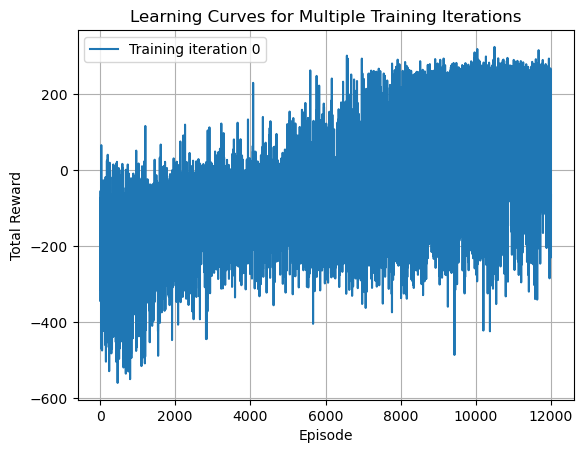

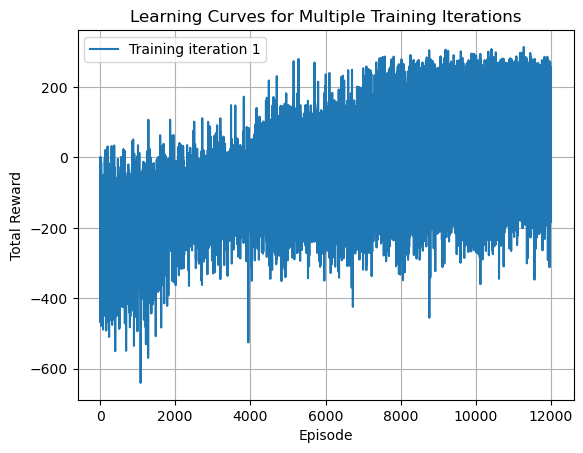

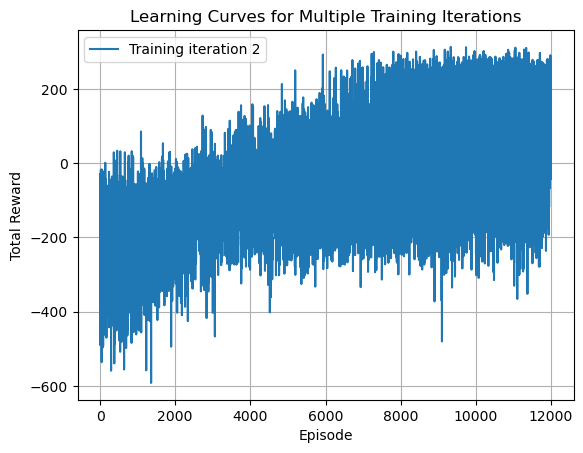

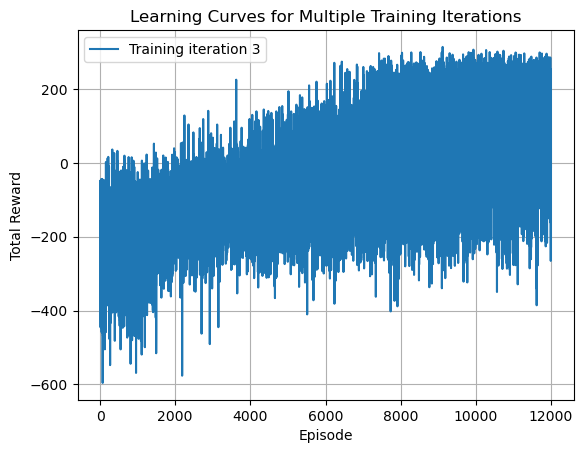

In [5]:
for i, rewards in enumerate(Q_rewards):
    plt.plot(rewards, label=f'Training iteration {i}')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Learning Curves for Multiple Training Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

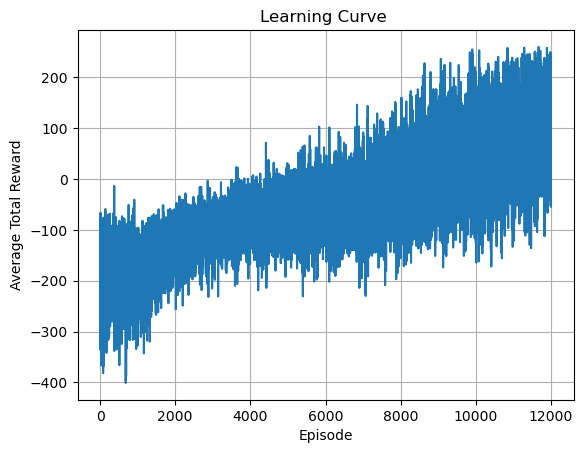

In [6]:
average_rewards = np.mean(Q_rewards, axis=0)
plt.plot(average_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Total Reward')
plt.title('Learning Curve ')
plt.grid(True)
plt.show()

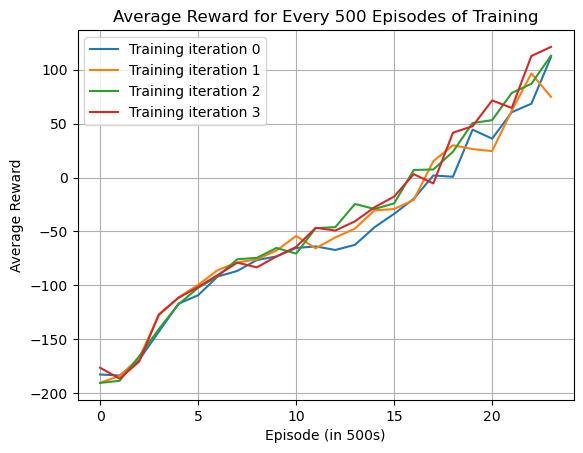

In [7]:
for i, average_rewards in enumerate(average_rewards_list):
    plt.plot(range(len(average_rewards)), average_rewards, label=f'Training iteration {i}')

plt.xlabel('Episode (in 500s)')
plt.ylabel('Average Reward')
plt.title('Average Reward for Every 500 Episodes of Training')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
n=500
for i, average_rewards in enumerate(average_rewards_list):
    print("Iteration: ", i+1)
    for row in average_rewards:
        print(f"Avg reward for {n} episodes: ", row)
        n+=500

Iteration:  1
Avg reward for 500 episodes:  -182.66943564770503
Avg reward for 1000 episodes:  -183.5488092565317
Avg reward for 1500 episodes:  -168.90012708483036
Avg reward for 2000 episodes:  -142.8787212128245
Avg reward for 2500 episodes:  -117.0614105638579
Avg reward for 3000 episodes:  -109.1637743199055
Avg reward for 3500 episodes:  -91.79538973160592
Avg reward for 4000 episodes:  -86.62745726867485
Avg reward for 4500 episodes:  -76.47706584730614
Avg reward for 5000 episodes:  -73.19639647203415
Avg reward for 5500 episodes:  -65.336767733817
Avg reward for 6000 episodes:  -63.89646161864954
Avg reward for 6500 episodes:  -67.18131389489112
Avg reward for 7000 episodes:  -62.41900997327144
Avg reward for 7500 episodes:  -46.07805561636199
Avg reward for 8000 episodes:  -33.65376732308905
Avg reward for 8500 episodes:  -19.72743641912599
Avg reward for 9000 episodes:  1.9188602158728645
Avg reward for 9500 episodes:  0.7107932370368116
Avg reward for 10000 episodes:  44.34

In [9]:
# Test Lunar Drone
env_test = gym.make('LunarLander-v2', render_mode="human")
state = env_test.reset()[0]
discrete_state_test = discretize_state(state)
done = False
while not done:
    action = np.argmax(Q_table[discrete_state_test])  
    next_state, reward, done, info, _ = env_test.step(action)
    discrete_state_test = discretize_state(next_state)
    env_test.render()

env_test.close()

In [10]:
env_test = gym.make('LunarLander-v2', render_mode="rgb_array")
state = env_test.reset()[0]
discrete_state_test = discretize_state(state)
done = False

output_path = r"C:\Users\sindr\Desktop\final_launch.avi"
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, 30.0, (600, 400))

while not done:
    action = np.argmax(Q_table[discrete_state_test])  
    next_state, reward, done, info, _ = env_test.step(action)
    discrete_state_test = discretize_state(next_state)
    frame = env_test.render()
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(frame)  

out.release()
env_test.close()